# Data Catalog KG Workshop with Neo4j

Click on the link below to open a Colab version of the notebook. You will be able to create your own version.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/zhongjie526/neo4j_data_catalog/blob/master/Data%20Catalog%20Management.ipynb" target="_blank">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo">Run your own notebook in Colab
    </a>
  </td>
</table>

---
## Target

Do data catalog analysis on a meta data knowledge graph of enterpise databases

## Context 

This notebook will load some simulated metadata for databases. We're going to leverage Neo4j native graph traversal capabilities and Neo4j Graph Data Science(GDS) to investigate through the data and find out patterns and insights pertaining the data catalog/meta data management.

---

## Let's get a graph database

We will use a Neo4j graph database created on the [Neo4j sandbox](https://neo4j.com/sandbox/).  
Once connected, on the _Select a project_ page, go to the section _Your own data_ and select the _Blank Sandbox_.  
Click on the _Create_ button at the bottom of the page.  
After few seconds, you should see the below.  
<img src="./img/sandbox_start.png" alt="Sandbox Start" width="75%" title="Sandbox Start">  

And once it's up and running, you can access the connection details by clicking on the top right down arrow and picking the *Connection details* tab.  
You will need 2 things:
* Password  
* Bolt URL   

<img src="./img/sandbox_details.png" alt="Sandbox Details" width="75%" title="Sandbox Details">  


In [1]:
# Install Neo4j Python Client and Neo4j GDS Python Client
import sys
!{sys.executable} -m pip install graphdatascience

from graphdatascience import GraphDataScience

In [2]:
# Configure Neo4j connection settings
neo4j_url = "neo4j://***.***.***.**8:7687"
neo4j_user = "neo4j"
neo4j_password = "*******"
neo4j_db = "neo4j"

# Create a Neo4j driver and GDS driver
gds = GraphDataScience(neo4j_url,auth=(neo4j_user,neo4j_password),database=neo4j_db)

print(f"GDS Version: {gds.version()}")

GDS Version: 2.3.6


# Data Ingestion from CSVs

In [145]:
data_location = 'https://raw.githubusercontent.com/zhongjie526/neo4j_data_catalog/master/data/'

gds.run_cypher("MATCH (n) DETACH DELETE n;")
gds.run_cypher("CREATE CONSTRAINT imp_uniq_tbl_name IF NOT EXISTS FOR (n: Table) REQUIRE (n.name) IS UNIQUE;")
gds.run_cypher("CREATE CONSTRAINT imp_uniq_ds_name IF NOT EXISTS FOR (n: Datasource) REQUIRE (n.name) IS UNIQUE;")
gds.run_cypher("CREATE CONSTRAINT imp_uniq_col_name IF NOT EXISTS FOR (n: Column) REQUIRE (n.name) IS UNIQUE;")
gds.run_cypher("CREATE CONSTRAINT imp_uniq_team_name IF NOT EXISTS FOR (n: Team) REQUIRE (n.name) IS UNIQUE;")
gds.run_cypher("CREATE CONSTRAINT imp_uniq_user_name IF NOT EXISTS FOR (n: User) REQUIRE (n.name) IS UNIQUE;")

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row 
WITH row WHERE row.name is not null
MERGE (n: Table { name: replace(row.name, '"', '') }) 
SET n._uid = row._uid
""",params={'path':data_location+'table_n0.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row 
WITH row WHERE NOT row.`name` IS NULL
MERGE (n: Datasource { name: replace(row.name, '"', '') }) 
SET n._uid = row._uid;
""",params={'path':data_location+'datasource_n1.csv'})


gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
WITH row WHERE NOT row.`name` IS NULL
MERGE (n: `Column` { `name`: replace(row.name, '"', '')})
SET n.`_uid` = row.`_uid`;
""",params={'path':data_location+'column_n2.csv'})


gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
with row WHERE NOT row.`name` IS NULL
MERGE (n: `Team` { `name`: replace(row.name, '"', '') })
SET n.`_uid` = row.`_uid`;
""",params={'path':data_location+'team_n3.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
with row WHERE NOT row.`name` IS NULL
MERGE (n: `User` { `name`: replace(row.name, '"', '')})
SET n.`_uid` = row.`_uid`;
""",params={'path':data_location+'user_n4.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
with row WHERE NOT row.`name` IS NULL
MERGE (n: `Table` { `name`: replace(row.name, '"', '')})
SET n.`_uid` = row.`_uid`;
""",params={'path':data_location+'table_n5.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
MATCH (source: `Table` { `name`: replace(row._from_name, '"', '')  })
MATCH (target: `Column` { `name`: replace(row._to_name, '"', '') })
MERGE (source)-[r: `HAS_COLUMN`]->(target)
SET r.`_uid` = row.`_uid`;
""",params={'path':data_location+'table_has_column_column_n1.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
MATCH (source: `Table` { `name`: replace(row._from_name, '"', '') })
MATCH (target: `Team` { `name`: replace(row._to_name, '"', '') })
MERGE (source)-[r: `OWNED_BY`]->(target)
SET r.`_uid` = row.`_uid`;
""",params={'path':data_location+'table_owned_by_team_n2.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
MATCH (source: `Team` { `name`: replace(row._from_name, '"', '') })
MATCH (target: `User` { `name`: replace(row._to_name, '"', '') })
MERGE (source)-[r: `HAS_USER`]->(target)
SET r.`_uid` = row.`_uid`;
""",params={'path':data_location+'team_has_user_user_n3.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
MATCH (source: `Table` { `name`: replace(row._from_name, '"', '') })
MATCH (target: `Datasource` { `name`: replace(row._to_name, '"', '') })
MERGE (source)-[r: `FROM_SOURCE`]->(target)
SET r.`_uid` = row.`_uid`;
""",params={'path':data_location+'table_from_source_datasource_n4.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
MATCH (source: `Table` { `name`: replace(row._from_name, '"', '') })
MATCH (target: `Column` { `name`: replace(row._to_name, '"', '')})
MERGE (source)-[r: `HAS_COLUMN`]->(target)
SET r.`_uid` = row.`_uid`;
""",params={'path':data_location+'table_has_column_column_n5.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
MATCH (source: `Table` { `name`: replace(row._from_name, '"', '') })
MATCH (target: `Team` { `name`: replace(row._to_name, '"', '') })
MERGE (source)-[r: `OWNED_BY`]->(target)
SET r.`_uid` = row.`_uid`;
""",params={'path':data_location+'table_owned_by_team_n6.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
MATCH (source: `Table` { `name`: replace(row._from_name, '"', '')  })
MATCH (target: `Table` { `name`: replace(row._to_name, '"', '') })
MERGE (source)-[r: `DERIVED_FROM`]->(target)
SET r.`_uid` = row.`_uid`;
""",params={'path':data_location+'table_derived_from_table_n7.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
MATCH (source: `User` { `name`: replace(row._from_name, '"', '')  })
MATCH (target: `Table` { `name`: replace(row._to_name, '"', '') })
MERGE (source)-[r: `HAS_ROLE`]->(target)
SET r.`role` = row.`role`;
""",params={'path':data_location+'user_has_role_table_n8.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
MATCH (source: `User` { `name`: replace(row._from_name, '"', '')  })
MATCH (target: `Table` { `name`: replace(row._to_name, '"', '')})
MERGE (source)-[r: `HAS_ROLE`]->(target)
SET r.`role` = row.`role`;
""",params={'path':data_location+'user_has_role_table_n9.csv'})


""


<img src="./img/data_model.png" alt="Data Model" width="600"/>

`This is the graph data model we ended up building, it is simple but sufficient for our exploratory purposese.`

## Identifying Orphaned Data

### In this example, we demonstrate how to quickly identify any data asset that is orphaned, i.e. with no owners and no access to any users and no dependency with other data assets. Reason for this could be missing metadata info or redundancy.

In [146]:
gds.run_cypher("""
match (t1:Table {name:"Products_Duplicate"}) detach delete t1
""")

gds.run_cypher("""
match (t1:Table {name:"Orphaned table"}) detach delete t1
""")

gds.run_cypher("""
merge (t1:Table {name:"Orphaned table"})
""")

gds.run_cypher("""
    MATCH (n:Table)
    WHERE NOT EXISTS(()-->(n))
    RETURN n.name
""")

,n.name
0,Orphaned table


## Check Data Lineage
**In the example below, we start with a random column name 'contract_end_date' and try to examine the data lineage of it using a simple Cypher query and visualize the output using the networkx and matplotlib librabries.**

In [17]:
result = gds.run_cypher("""
    match (c:Column {name:'contract_end_date'})-[r1:HAS_COLUMN]-(t:Table)-[r2:FROM_SOURCE]-(s:Datasource) 
    return t.name as table,type(r1) as rel1,c.name as column,type(r2) as rel2,s.name as datasource
""")

result

,table,rel1,column,rel2,datasource
0,Products,HAS_COLUMN,contract_end_date,FROM_SOURCE,HR
1,Products,HAS_COLUMN,contract_end_date,FROM_SOURCE,ERP
2,Employees,HAS_COLUMN,contract_end_date,FROM_SOURCE,HR


<img src="./img/lineage.png" alt="Data Lineage" width="700" style="float:left;margin-right:10px"/>

`This is how the data lineage would look like in Bloom. Which we are gonna explore in a minute!`

### Visulizing graph in python

**Alternatively, we can visualize the same graph in python using the networkx and matplotlib libraries**

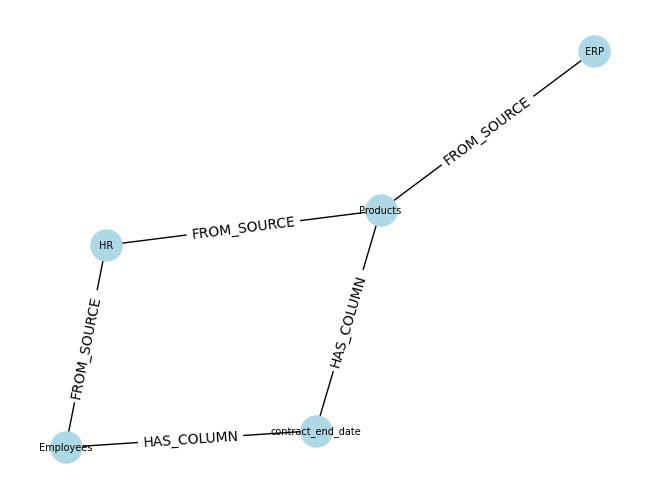

In [3]:
import networkx as nx
import matplotlib.pyplot as plt


plt.clf()
with driver.session() as session:
    result = session.run("match (c:Column {name:'contract_end_date'})-[r1:HAS_COLUMN]-(t:Table)-[r2:FROM_SOURCE]-(s:Datasource) return c,r1,t,r2,s")

    # Create a Network object
    G = nx.Graph()

    # Add the node to the network
    for record in result:
        node = record["c"]
        G.add_node(node.id, label=node["name"], color="lightblue")
        node = record["t"]
        G.add_node(node.id, label=node["name"], color="lightblue")
        node = record["s"]
        G.add_node(node.id, label=node["name"], color="lightblue")
        rel = record["r1"]
        G.add_edge(rel.start_node.id, rel.end_node.id,label=rel.type)
        rel = record["r2"]
        G.add_edge(rel.start_node.id, rel.end_node.id,label=rel.type)


# Visualize the network
pos = nx.spring_layout(G)
labels = nx.get_node_attributes(G, "label")
edge_labels = nx.get_edge_attributes(G, "label")

nx.draw(G, pos, labels = labels,with_labels=True, node_color="lightblue", node_size=500, font_size=7)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

``As shown in the graph above, column "contract_end_date" may come from both Table "Products" and "Emplyees" which are data sources ERP and HR respectively``

## Finding Critical Data Assets (Access) by Degree Centrality

**Degree Centrality measures the number of connections or relationships a node has in a graph. In the context of data quality analysis, you can use Degree Centrality to identify metadata elements (nodes) that have a high number of relationships, indicating their significance or importance in the data ecosystem. Nodes with high Degree Centrality may represent critical tables, columns, or data entities that require careful attention and quality assessment.**

In [148]:
gds.run_cypher("""
CALL gds.graph.drop('myGraph',false) YIELD graphName;
""")


gds.run_cypher("""
CALL gds.graph.project(
  'myGraph',
  ['Table','User'],
  {
    HAS_ROLE: {
      orientation: 'REVERSE'
    }
  }
)
""")

gds.run_cypher("""
CALL gds.degree.stream('myGraph')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score AS owners
ORDER BY owners DESC, name DESC
LIMIT 5
""")


,name,owners
0,Orders_Summary,19.0
1,Customer_Summary,19.0
2,Products,13.0
3,Customers,12.0
4,Invoices,9.0


## Finding Critical Data Assets (Dependency) by Hyperlink-Induced Topic Search (HITS)

### The Hyperlink-Induced Topic Search (HITS) is a link analysis algorithm that rates nodes based on two scores, a hub score and an authority score. The authority score estimates the importance of the node within the network. The hub score estimates the value of its relationships to other nodes. 

### In the following example, we create a mock table called "Mother_Table" and make all other table "DERIVED_FROM" it. Running HITS confirms the importance of this table as all other table depend on it.

In [149]:
gds.run_cypher("""
match (n:Table {name:"Mother_Table"}) detach delete n
""")

gds.run_cypher("""
match (t:Table)
merge (n:Table {name:"Mother_Table"})
with t,n
merge (t)-[:DERIVED_FROM]->(n)
""")


gds.run_cypher("""
CALL gds.graph.drop('myGraph',false) YIELD graphName;
""")


gds.run_cypher("""
CALL gds.graph.project(
  'myGraph',
  ['Table'],
  {DERIVED_FROM: {indexInverse: false}}
)
""")

gds.run_cypher("""
CALL gds.alpha.hits.stream('myGraph', {hitsIterations: 50})
YIELD nodeId, values
RETURN gds.util.asNode(nodeId).name AS Name, values.auth AS auth, values.hub as hub
ORDER BY auth DESC
LIMIT 5
""")

,Name,auth,hub
0,Mother_Table,0.981624,0.000000
1,Employees,0.134933,0.341243
2,Departments,0.134933,0.341243
3,Invoices,0.000000,0.341243
4,Products,0.000000,0.341243


## Identifying Duplicate Data

**In the following example, we create an "almost" duplicate of a table by making them sharing 80% of the columns. Then we run Jaccard similarity score between all the tables based on their columns and return the results sorted descendingly by the Jaccard score.**

In [150]:
gds.run_cypher("""
match (t1:Table {name:"Products_Duplicate"}) detach delete t1
""")

gds.run_cypher("""
match (t:Table {name:"Products"})--(c:Column)  with c
merge (t1:Table {name:"Products_Duplicate"})
with t1,c, rand() as r
where r>0.2
merge (t1)-[:HAS_COLUMN]->(c)
""")

gds.run_cypher("""
MATCH (n1:Table)-[*..1]-(common:Column)
WITH n1,COLLECT(DISTINCT common) AS set1
MATCH (n2:Table)-[*..1]-(common:Column)
where id(n1)<id(n2)
WITH n1, set1, n2, COLLECT(DISTINCT common) AS set2
WITH n1, set1, n2, apoc.coll.intersection(set1, set2) AS intersection,
     apoc.coll.union(set1, set2) AS union
with n1, n2, size(intersection)*1.0 / size(union) AS similarity order by similarity desc
where similarity>0.3
return n1.name as table1,n2.name as table2,similarity
""")


,table1,table2,similarity
0,Products,Products_Duplicate,0.800000
1,Products,Customers,0.400000
2,Customer_Summary,Departments,0.333333
3,Customers,Products_Duplicate,0.315789


`Surpringly, our mocked duplicate table ended up first on the rank!`

## Data Assets Segmentation using Weakly Connected Components (WCC)

In [165]:
gds.run_cypher("""
CALL gds.graph.drop('myGraph',false) YIELD graphName;
""")

gds.run_cypher("""

match (a:Table {name:"a"})
match (b:Table {name:"b"})
match (c:Table {name:"c"})
match (d:Table {name:"d"})

detach delete a,b,c,d
""")


gds.run_cypher("""
merge (a:Table {name:"a"})
merge (b:Table {name:"b"})
merge (c:Table {name:"c"})
merge (d:Table {name:"d"})
merge (b)-[:DERIVED_FROM]->(a)
merge (c)-[:DERIVED_FROM]->(a)
merge (d)-[:DERIVED_FROM]->(a)
merge (d)-[:DERIVED_FROM]->(b)
merge (c)-[:DERIVED_FROM]->(b)
""")

gds.run_cypher("""
CALL gds.graph.project(
    'myGraph',
    'Table',
    {
        DERIVED_FROM: {
            orientation: 'UNDIRECTED'
        }
    }
)

""")

gds.run_cypher("""
CALL gds.wcc.stream('myGraph')
YIELD nodeId, componentId
RETURN gds.util.asNode(nodeId).name AS name, componentId
ORDER BY componentId, name
""")

,name,componentId
0,Customer_Summary,0
1,Customers,0
2,Departments,0
3,Employees,0
4,Invoices,0
5,Mother_Table,0
6,Orders_Summary,0
7,Orphaned table,0
8,Products,0
9,Products_Duplicate,9


`As you can see here, table a,b,c and d are classified as a cluster of its own. So is the Product_Duplicate table as it has no relationship to other tables `